# 01 - Data Exploration and Feature Engineering
## Healthcare Provider Fraud Detection
### Team: Carol, Salma G, Salma E, Farah

In [10]:
# === IMPORTS & SETUP ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported")

✅ Libraries imported


In [11]:
# === LOAD ALL DATASETS - ADJUSTED PATHS ===
beneficiary = pd.read_csv('Train_Beneficiarydata.csv')
inpatient = pd.read_csv('Train_Inpatientdata.csv')
outpatient = pd.read_csv('Train_Outpatientdata.csv')
labels = pd.read_csv('Train.csv')

In [12]:
# === LOAD ALL DATASETS ===
beneficiary = pd.read_csv('Train_Beneficiarydata.csv')
inpatient = pd.read_csv('Train_Inpatientdata.csv')
outpatient = pd.read_csv('Train_Outpatientdata.csv')
labels = pd.read_csv('Train.csv')

print("✅ Datasets loaded successfully!")
print(f"Beneficiary: {beneficiary.shape}")
print(f"Inpatient: {inpatient.shape}")
print(f"Outpatient: {outpatient.shape}")
print(f"Labels: {labels.shape}")

✅ Datasets loaded successfully!
Beneficiary: (138556, 25)
Inpatient: (40474, 30)
Outpatient: (517737, 27)
Labels: (5410, 2)


In [13]:
# === DATA UNDERSTANDING ===
print("🔍 DATASET RELATIONSHIPS:")
print(f"Unique Providers in labels: {labels['Provider'].nunique()}")
print(f"Unique Beneficiaries: {beneficiary['BeneID'].nunique()}")
print(f"\nClass Distribution:")
print(labels['PotentialFraud'].value_counts())
print(labels['PotentialFraud'].value_counts(normalize=True))

🔍 DATASET RELATIONSHIPS:
Unique Providers in labels: 5410
Unique Beneficiaries: 138556

Class Distribution:
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64
PotentialFraud
No     0.90647
Yes    0.09353
Name: proportion, dtype: float64


In [14]:
# === DATA QUALITY CHECK ===
def check_missing(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing_Count': missing, 'Missing_Percent': missing_pct})
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    if len(missing_df) > 0:
        print(f"\n📊 {name} - Missing Values:")
        print(missing_df.head())
    return missing_df

check_missing(beneficiary, "Beneficiary")
check_missing(inpatient, "Inpatient")
check_missing(outpatient, "Outpatient")
check_missing(labels, "Labels")


📊 Beneficiary - Missing Values:
     Missing_Count  Missing_Percent
DOD         137135        98.974422

📊 Inpatient - Missing Values:
                     Missing_Count  Missing_Percent
ClmProcedureCode_6           40474       100.000000
ClmProcedureCode_5           40465        99.977764
ClmProcedureCode_4           40358        99.713396
ClmProcedureCode_3           39509        97.615753
ClmDiagnosisCode_10          36547        90.297475

📊 Outpatient - Missing Values:
                    Missing_Count  Missing_Percent
ClmProcedureCode_6         517737       100.000000
ClmProcedureCode_5         517737       100.000000
ClmProcedureCode_4         517735        99.999614
ClmProcedureCode_3         517733        99.999227
ClmProcedureCode_2         517701        99.993047


,Missing_Count,Missing_Percent


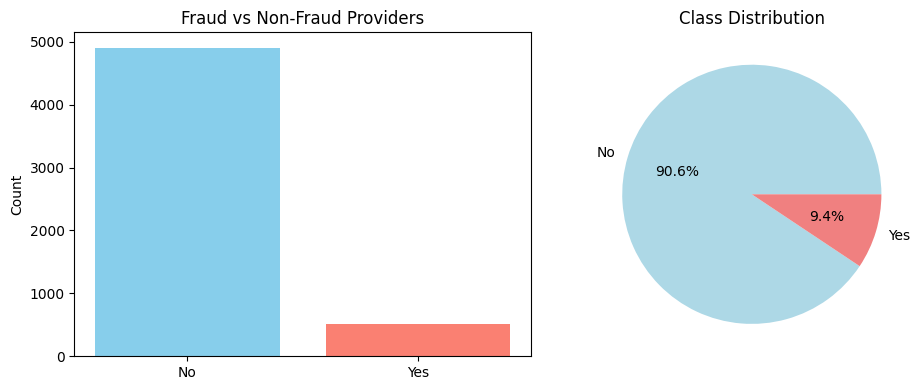

Imbalance Ratio: 9.7:1


In [15]:
# === TARGET DISTRIBUTION VISUALIZATION ===
plt.figure(figsize=(10, 4))
fraud_counts = labels['PotentialFraud'].value_counts()
plt.subplot(1, 2, 1)
plt.bar(fraud_counts.index, fraud_counts.values, color=['skyblue', 'salmon'])
plt.title('Fraud vs Non-Fraud Providers')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(fraud_counts.values, labels=fraud_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

print(f"Imbalance Ratio: {fraud_counts['No']/fraud_counts['Yes']:.1f}:1")

In [16]:
# === FEATURE ENGINEERING: PROVIDER-LEVEL AGGREGATION ===
def create_provider_features(provider_list):
    """Create comprehensive provider-level features"""
    features = []

    for provider in provider_list:
        # Get provider's data
        provider_inpatient = inpatient[inpatient['Provider'] == provider]
        provider_outpatient = outpatient[outpatient['Provider'] == provider]

        # Get beneficiaries for this provider
        provider_bene_ids = pd.concat([provider_inpatient['BeneID'], provider_outpatient['BeneID']]).unique()
        provider_beneficiaries = beneficiary[beneficiary['BeneID'].isin(provider_bene_ids)]

        # Basic counts and volumes
        total_claims = len(provider_inpatient) + len(provider_outpatient)
        inpatient_ratio = len(provider_inpatient) / total_claims if total_claims > 0 else 0

        # Financial features
        total_reimbursement = (provider_inpatient['InscClaimAmtReimbursed'].sum() +
                             provider_outpatient['InscClaimAmtReimbursed'].sum())
        avg_claim_amount = total_reimbursement / total_claims if total_claims > 0 else 0

        # Patient demographics - IMPROVED DATE HANDLING
        avg_patient_age = 65.0  # Default
        if not provider_beneficiaries.empty and 'DOB' in provider_beneficiaries.columns:
            try:
                # Use a reasonable reference date based on your data context
                reference_date = pd.to_datetime('2020-12-31')  # Adjust if needed
                provider_beneficiaries['DOB'] = pd.to_datetime(provider_beneficiaries['DOB'], errors='coerce')
                avg_patient_age = (reference_date - provider_beneficiaries['DOB']).dt.days / 365.25
                avg_patient_age = avg_patient_age.mean()
            except Exception as e:
                avg_patient_age = 65.0

        # Chronic conditions (average across patients)
        chronic_cols = [col for col in provider_beneficiaries.columns if 'ChronicCond' in col]
        avg_chronic_conditions = provider_beneficiaries[chronic_cols].mean().mean() if len(chronic_cols) > 0 else 0

        # Physician utilization
        unique_physicians = pd.concat([
            provider_inpatient['AttendingPhysician'],
            provider_outpatient['AttendingPhysician']
        ]).nunique()

        # Create feature dictionary
        provider_feature = {
            'Provider': provider,
            'Total_Claims': total_claims,
            'Inpatient_Ratio': inpatient_ratio,
            'Total_Reimbursement': total_reimbursement,
            'Avg_Claim_Amount': avg_claim_amount,
            'Avg_Patient_Age': avg_patient_age,
            'Avg_Chronic_Conditions': avg_chronic_conditions,
            'Unique_Physicians': unique_physicians,
            'Claims_per_Physician': total_claims / unique_physicians if unique_physicians > 0 else 0
        }

        features.append(provider_feature)

    return pd.DataFrame(features)

print("🚀 Creating provider-level features...")
provider_features = create_provider_features(labels['Provider'].unique())
print(f"✅ Created features for {len(provider_features)} providers")

🚀 Creating provider-level features...
✅ Created features for 5410 providers


In [17]:
# === CREATE FINAL DATASET ===
final_dataset = provider_features.merge(labels, on='Provider', how='left')

print("📊 FINAL DATASET SUMMARY:")
print(f"Shape: {final_dataset.shape}")
print(f"Columns: {final_dataset.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(final_dataset.head(3))

print(f"\n🔍 Fraud distribution in final dataset:")
print(final_dataset['PotentialFraud'].value_counts())
print(final_dataset['PotentialFraud'].value_counts(normalize=True))
# === CREATE FINAL DATASET ===
final_dataset = provider_features.merge(labels, on='Provider', how='left')

# ADD VALIDATION CHECKS
print("🔍 Final dataset validation:")
print(f"Missing values: {final_dataset.isnull().sum().sum()}")
print(f"Duplicate providers: {final_dataset['Provider'].duplicated().sum()}")

print("📊 FINAL DATASET SUMMARY:")
print(f"Shape: {final_dataset.shape}")
print(f"Columns: {final_dataset.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(final_dataset.head(3))

print(f"\n🔎 Fraud distribution in final dataset:")
print(final_dataset['PotentialFraud'].value_counts())
print(final_dataset['PotentialFraud'].value_counts(normalize=True))

📊 FINAL DATASET SUMMARY:
Shape: (5410, 10)
Columns: ['Provider', 'Total_Claims', 'Inpatient_Ratio', 'Total_Reimbursement', 'Avg_Claim_Amount', 'Avg_Patient_Age', 'Avg_Chronic_Conditions', 'Unique_Physicians', 'Claims_per_Physician', 'PotentialFraud']

First 3 rows:
   Provider  Total_Claims  Inpatient_Ratio  Total_Reimbursement  \
0  PRV51001            25         0.200000               104640   
1  PRV51003           132         0.469697               605670   
2  PRV51004           149         0.000000                52170   

   Avg_Claim_Amount  Avg_Patient_Age  Avg_Chronic_Conditions  \
0       4185.600000        89.670431                1.496212   
1       4588.409091        80.474350                1.602953   
2        350.134228        83.946771                1.607378   

   Unique_Physicians  Claims_per_Physician PotentialFraud  
0                 14              1.785714             No  
1                 44              3.000000            Yes  
2                 38        

In [19]:
# === SAVE PROCESSED DATA ===
final_dataset.to_csv('final_provider_dataset.csv', index=False)
print("💾 Saved final dataset to: final_provider_dataset.csv")
print("✅ NOTEBOOK 1 COMPLETED - Ready for modeling!")

💾 Saved final dataset to: final_provider_dataset.csv
✅ NOTEBOOK 1 COMPLETED - Ready for modeling!
